## Dimensional Reduction

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA

from nose.tools import assert_equal, assert_is_instance, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal
from pandas.util.testing import assert_frame_equal

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('delta.csv', index_col='Aircraft')

In [19]:
print(df.head())

                  Seat Width (Club)  Seat Pitch (Club)  Seat (Club)  \
Aircraft                                                              
Airbus A319                     0.0                  0            0   
Airbus A319 VIP                19.4                 44           12   
Airbus A320                     0.0                  0            0   
Airbus A320 32-R                0.0                  0            0   
Airbus A330-200                 0.0                  0            0   

                  Seat Width (First Class)  Seat Pitch (First Class)  \
Aircraft                                                               
Airbus A319                           21.0                      36.0   
Airbus A319 VIP                       19.4                      40.0   
Airbus A320                           21.0                      36.0   
Airbus A320 32-R                      21.0                      36.0   
Airbus A330-200                        0.0                       0.0  

### Physical Characteristics

In [20]:
def plot_pairgrid(df):
    '''
    Uses seaborn.PairGrid to visualize the attributes related to the six physical characteristics.
    Diagonal plots are histograms. The off-diagonal plots are scatter plots.
    
    Parameters
    ----------
    df: A pandas.DataFrame. Comes from importing delta.csv.
    
    Returns
    -------
    A seaborn.axisgrid.PairGrid instance.
    '''
    
    new=df[['Cruising Speed (mph)', 'Range (miles)', 'Engines','Wingspan (ft)', 'Tail Height (ft)', 'Length (ft)']]
    ax=sns.PairGrid(new)
    ax.map_diag(plt.hist)
    ax.map_offdiag(plt.scatter)
    return ax

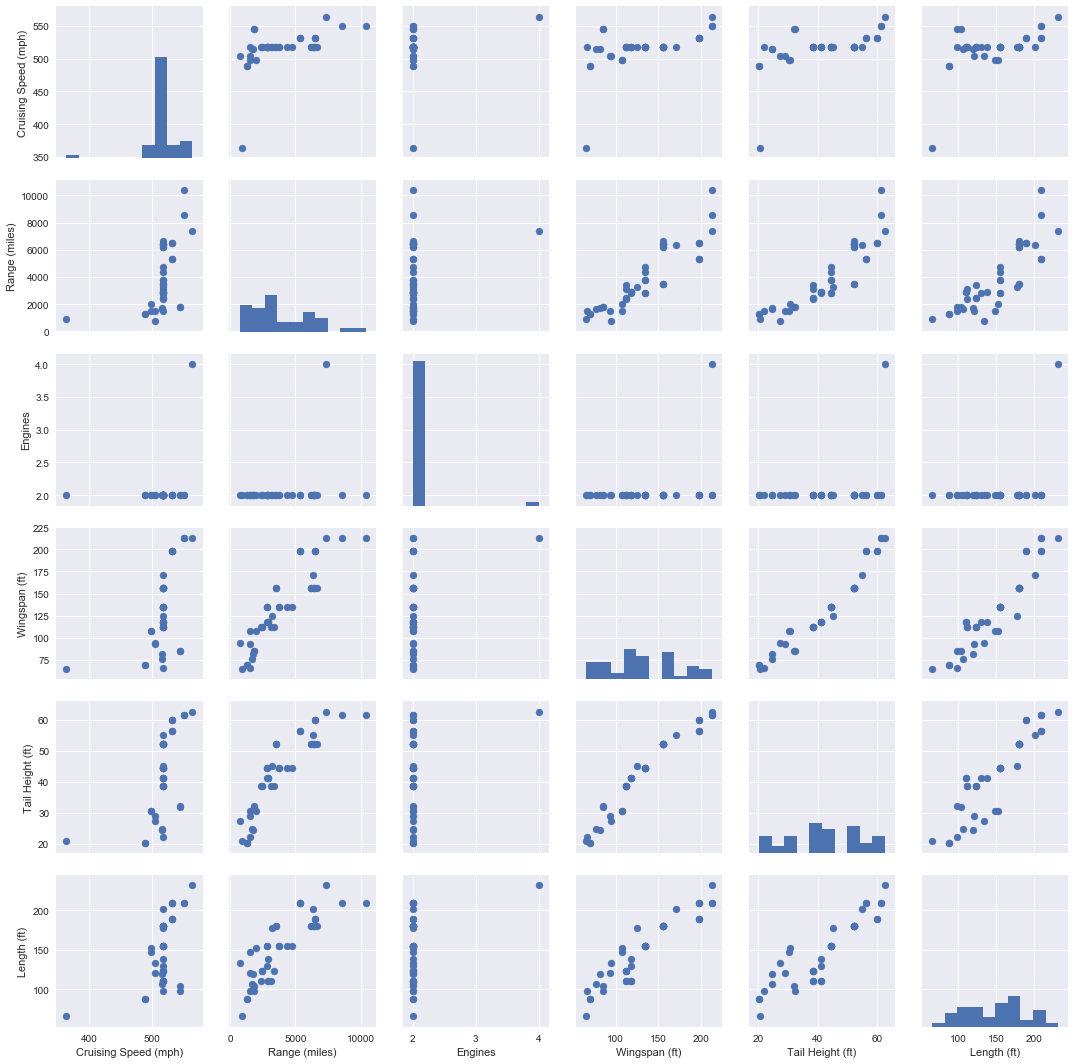

In [16]:
pg=plot_pairgrid(df)

In [17]:
cols = ['Cruising Speed (mph)', 'Range (miles)', 'Engines',
        'Wingspan (ft)', 'Tail Height (ft)', 'Length (ft)']

assert_is_instance(pg.fig, plt.Figure)
assert_equal(set(pg.data.columns), set(cols))

for ax in pg.diag_axes:
    assert_equal(len(ax.patches), 10)

for i, j in zip(*np.triu_indices_from(pg.axes, 1)):
    ax = pg.axes[i, j]
    x_in = df[cols[j]]
    y_in = df[cols[i]]
    x_out, y_out = ax.collections[0].get_offsets().T
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.tril_indices_from(pg.axes, -1)):
    ax = pg.axes[i, j]
    x_in = df[cols[j]]
    y_in = df[cols[i]]
    x_out, y_out = ax.collections[0].get_offsets().T
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.diag_indices_from(pg.axes)):
    ax = pg.axes[i, j]
    assert_equal(len(ax.collections), 0)

### Principal Components Analysis (A naive approach)

In [19]:
def fit_pca(df, n_components):
    '''
    Uses sklearn.decomposition.PCA to fit a PCA model on "df".
    
    Parameters
    ----------
    df: A pandas.DataFrame. Comes from delta.csv.
    n_components: An int. Number of principal components to keep.
    
    Returns
    -------
    An sklearn.decomposition.pca.PCA instance.
    '''
    
    pca = PCA(n_components=n_components)
    pca.fit(df)
    return pca

In [20]:
pca_naive = fit_pca(df, n_components=df.shape[1])

In [21]:
assert_is_instance(pca_naive, PCA)
assert_almost_equal(pca_naive.explained_variance_ratio_.sum(), 1.0, 3)
assert_equal(pca_naive.n_components_, df.shape[1])
assert_equal(pca_naive.whiten, False)

### Plot explained variance

In [60]:
def plot_naive_variance(pca):
    '''
    Plots the variance explained by each of the principal components.
    Attributes are not scaled, hence a naive approach.
    
    Parameters
    ----------
    pca: An sklearn.decomposition.pca.PCA instance.
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    
    sns.set(style="ticks", font_scale=2.0)
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(pca.explained_variance_ratio_)
    ax.set_xlabel('principal component')
    ax.set_ylabel('Explained Variance')
    ax.set_title('Attributes not scaled')
    sns.despine(offset=5)
    return ax

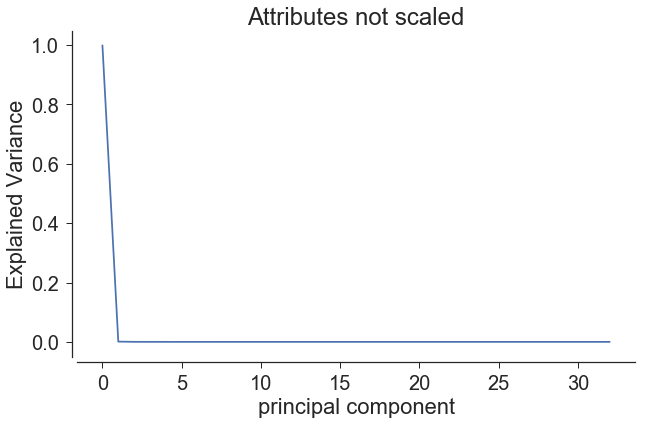

In [61]:
naive_var = plot_naive_variance(pca_naive)

In [62]:
assert_is_instance(naive_var, mpl.axes.Axes)
assert_equal(len(naive_var.lines), 1)

assert_is_not(len(naive_var.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(naive_var.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")
assert_is_not(naive_var.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")

xdata, ydata = naive_var.lines[0].get_xydata().T
assert_array_equal(xdata, list(range(df.shape[1])))
assert_array_almost_equal(ydata, pca_naive.explained_variance_ratio_)

In [63]:
abs_val = np.abs(pca_naive.components_[0])
max_pos = abs_val.argmax()
max_val = abs_val.max()

print('"{0}" accounts for {1:0.3f} % of the variance.'.format(df.columns[max_pos], max_val))


"Range (miles)" accounts for 0.999 % of the variance.


### Standardization

In [68]:
def standardize(df):
    '''
    Uses sklearn.preprocessing.StandardScaler to make each features look like
    a Gaussian with zero mean and unit variance.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A numpy array.
    '''
    
    scaler=StandardScaler().fit(df)
    new=scaler.transform(df)  
    return new

In [69]:
scaled = standardize(df)

In [70]:
rng = np.random.RandomState(0)
n_samples, n_features = 4, 5

df_t1 = pd.DataFrame(
    rng.randn(n_samples, n_features),
    index=[i for i in 'abcd'],
    columns=[c for c  in 'abcde']
    )
df_t1.loc[:, 'a'] = 0.0  # make first feature zero

scaled_t1 = standardize(df_t1)

assert_is_not(df_t1, scaled_t1)
assert_is_instance(scaled_t1, np.ndarray)
assert_array_almost_equal(
    scaled_t1.mean(axis=0),
    n_features * [0.0] # scaled data should have mean zero
    ) 
assert_array_almost_equal(
    scaled_t1.std(axis=0),
    [0., 1., 1., 1., 1.] # unit variance except for 1st feature
    )

In [93]:
n_components = 10
pca = fit_pca(scaled, n_components=n_components)

### Plot explained variance

In [139]:
def plot_scaled_variance(pca):
    '''
    Plots the variance explained by each of the principal components.
    Features are scaled with sklearn.StandardScaler.
    
    Parameters
    ----------
    pca: An sklearn.decomposition.pca.PCA instance.
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    
    sns.set(style="ticks", font_scale=2.0)
    fig, ax = plt.subplots(figsize=(8,6))
    plt.plot(pca.explained_variance_ratio_)
    var = np.cumsum(pca.explained_variance_ratio_)
    vls = np.array([np.argmax(var > 0.85)])
    ax.vlines(vls, 0.0, 0.2, linestyles='dashed')
    ax.text(vls[0], 0.21, str('85%'), fontsize = 18, color=sns.xkcd_rgb["pale red"], horizontalalignment='center')
    ax.set_xlabel('Principal component')
    ax.set_ylabel('Explained Variance')
    ax.set_title('Features are scaled')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 0.45)
    sns.despine()
    return ax

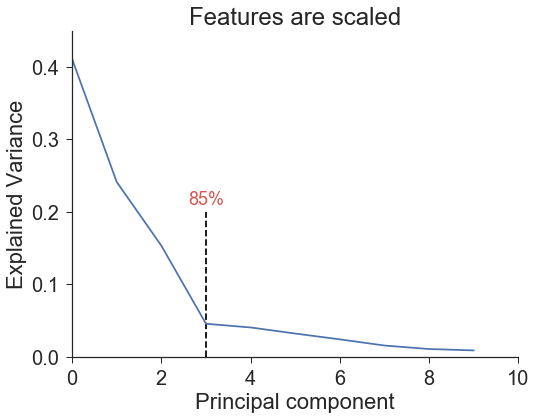

In [140]:
ax=plot_scaled_variance(pca)

In [133]:
assert_is_instance(ax, mpl.axes.Axes)
assert_equal(len(ax.lines), 1)

assert_is_not(len(ax.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax.xaxis.get_label_text(), '', msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax.yaxis.get_label_text(), '', msg="Change the y-axis label to something more descriptive.")

xdata, ydata = ax.lines[0].get_xydata().T
assert_array_equal(xdata, list(range(n_components)))
assert_array_almost_equal(ydata, pca.explained_variance_ratio_)

In [134]:
def reduce(pca, array):
    '''
    Applies the `pca` model on array.
    
    Parameters
    ----------
    pca: An sklearn.decomposition.PCA instance.
    
    Returns
    -------
    A Numpy array
    '''
    
    reduced=pca.fit_transform(array)
    return reduced

In [135]:
reduced = reduce(pca, scaled)

In [136]:
assert_is_instance(reduced, np.ndarray)
assert_array_almost_equal(reduced, pca.fit_transform(scaled))